In [1]:
import foscat.scat_cov as sc
import numpy as np
import xarray as xr
import xdggs
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
ds=xr.load_dataset('/mnt/d/DerivTest/CER_PSI_ARC_3D_012_DRIFT_ASCAT_B_20241029_20241101_v02.0_fv01.0.nc')
ds=xr.load_dataset('/mnt/d/DerivTest/CER_PSI_ARC_3D_012_DRIFT_ASCAT_B_20241230_20250102_v02.0_fv01.0.nc')
ds

<xarray.Dataset> Size: 262kB
Dimensions:                          (y: 66, x: 76, time: 1, nv: 2)
Coordinates:
    lat                              (y, x) float64 40kB 56.73 57.1 ... 66.86
    lon                              (y, x) float64 40kB 178.6 177.9 ... 12.05
  * time                             (time) datetime64[ns] 8B 2024-12-30
  * x                                (x) float64 608B -2.556e+03 ... 2.131e+03
  * y                                (y) float64 528B 2.681e+03 ... -1.381e+03
Dimensions without coordinates: nv
Data variables:
    Polar_Stereographic_Grid         float64 8B nan
    end_lat_of_sea_ice_displacement  (y, x) float64 40kB 56.73 57.1 ... 66.86
    end_lon_of_sea_ice_displacement  (y, x) float64 40kB 178.6 177.9 ... 12.05
    time_bounds                      (nv) datetime64[ns] 16B 2024-12-30 2025-...
    rejection_flags                  (y, x) float32 20kB 32.0 32.0 ... 32.0 32.0
    eastward_sea_ice_displacement    (y, x) float64 40kB nan nan nan ... nan nan
    northward_sea_ice_displacement   (y, x) float64 40kB nan nan nan ... nan nan
Attributes: (12/72)
    id:                              CERSAT-L3-ARC-SIDRIFT-ASCAT_METOB_B-3D-012
    title:                           3-daily sea-ice drift vectors from ASCAT...
    summary:                         This dataset contains sea-ice displaceme...
    references:                      https://www.researchgate.net/publication...
    acknowledgement:                 We are grateful to CERSAT for providing ...
    citation:                        Ifremer / CERSAT. 2022.  Arctic Sea-ice ...
    ...                              ...
    geospatial_vertical_positive:    up
    geospatial_bounds:               POLYGON ((-180. 90., -180. 60., 180. 60....
    geospatial_bounds_crs:           EPSG:3413
    geospatial_bounds_vertical_crs:  EPSG:5831
    date_created:                    2025-02-03T11:29:40Z
    date_modified:                   2025-02-03T11:29:40Z

In [3]:
# Define the HEALPix resolution
nside = 64

# Get the data, longitude, and latitude
idata1 = ds.eastward_sea_ice_displacement.compute().values.flatten()
idata2 = ds.northward_sea_ice_displacement.compute().values.flatten()
longitude = ds.lon.compute().values.flatten()
latitude = ds.lat.compute().values.flatten()
#

# Compute the corresponding HEALPix cell indices at nside=nside_up to ensur the computation of all pixel at higher resolution
input_cell_ids = hp.ang2pix(nside, -longitude, latitude, lonlat=True, nest=True)

im1=np.bincount(input_cell_ids[np.isfinite(idata1)],weights=idata1[np.isfinite(idata1)])
im2=np.bincount(input_cell_ids[np.isfinite(idata1)],weights=idata2[np.isfinite(idata1)])
imw=np.bincount(input_cell_ids[np.isfinite(idata1)])

#if nside>nside_up:
#    input_cell_ids = (nside//nside_up)**2*np.repeat(input_cell_ids,(nside//nside_up)**2)+np.tile(np.arange((nside//nside_up)**2),input_cell_ids.shape[0])
    
input_cell_ids = np.unique(input_cell_ids[np.isfinite(idata1)])
cell_ids = input_cell_ids
data1 = im1[cell_ids]/imw[cell_ids]
data2 = im2[cell_ids]/imw[cell_ids]
del im1
del im2
del imw

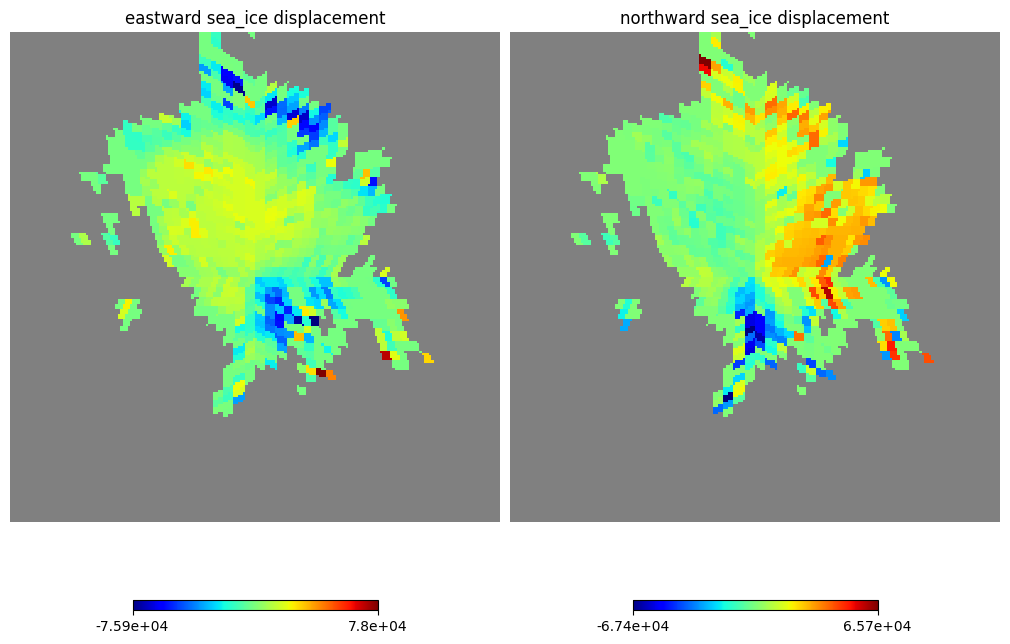

In [4]:
def plot_result(data,cell_ids,nside,hold=None,sub=None,title=None,unit=None,vmin=None,vmax=None):
    im=np.ones([12*nside**2])*hp.UNSEEN
    im[cell_ids]=data
    if vmin is None:
        vmin=data.min()
    if vmax is None:
        vmax=data.max()
    hp.gnomview(im,cmap='jet',nest=True,rot=[0,90.0],reso=16,hold=hold,sub=sub,notext=True,title=title,unit=unit,min=vmin,max=vmax)

plt.figure(figsize=(10,10))
plot_result(data1,cell_ids,nside,hold=False,sub=(1,2,1),title='eastward sea_ice displacement')
plot_result(data2,cell_ids,nside,hold=False,sub=(1,2,2),title='northward sea_ice displacement')

In [5]:
f=sc.funct(BACKEND='torch')

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/foscat/BkTorch.py:152: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return self.backend.sparse_coo_tensor(indice.T, w, dense_shape).to_sparse_csr().to(self.torch_device)


In [6]:
rx=f.eval(data1,cell_ids=cell_ids,nside=nside)
ry=f.eval(data2,cell_ids=cell_ids,nside=nside)
rcross=f.eval(data1,image2=data2,cell_ids=cell_ids,nside=nside)

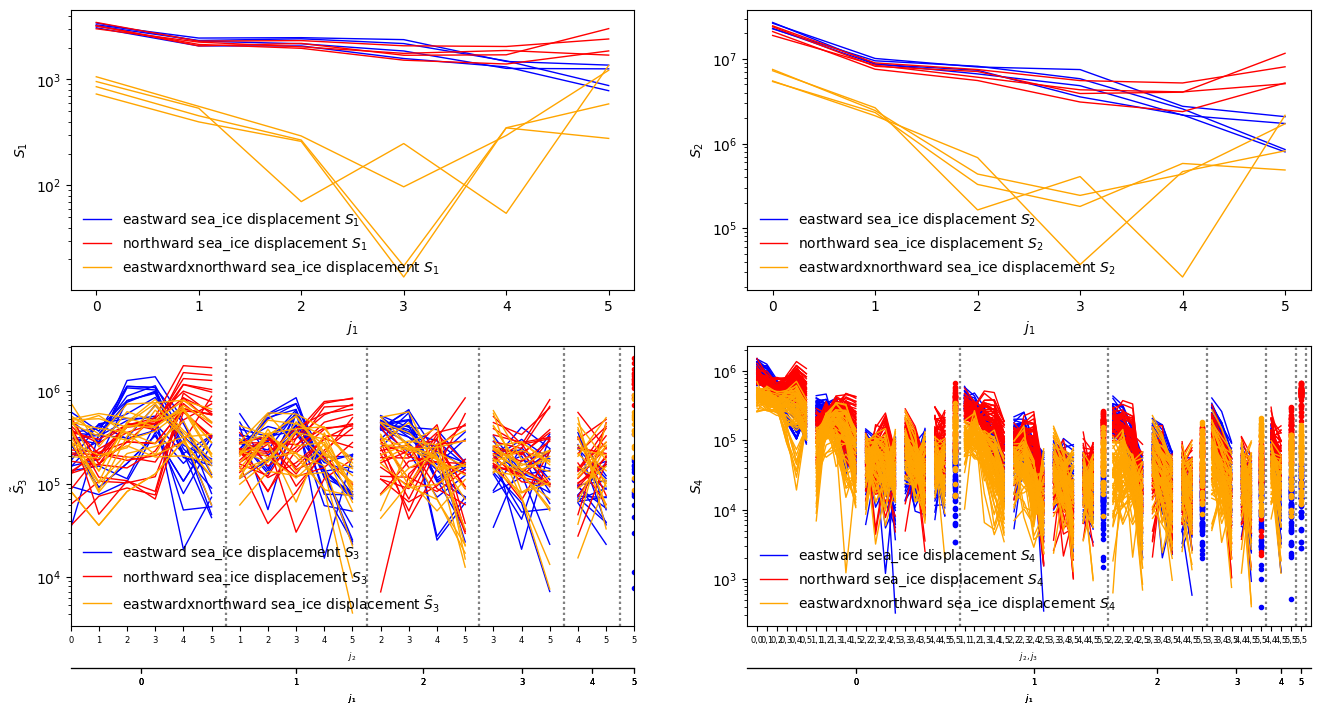

In [7]:
rx.plot(color='b',name='eastward sea_ice displacement')
ry.plot(color='r',name='northward sea_ice displacement',hold=False)
rcross.plot(color='orange',name='eastwardxnorthward sea_ice displacement',hold=False)